# Data Processing (with sorted laps)

Determine which laps to keep while avoiding eliminating all first laps. Bleh.
1. Import telemetry .csv
1. Import image data
1. Convert image data
1. Save image, telemetry, and target datasets

In [1]:
## Imports
import numpy as np
import pandas as pd
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle

from tensorflow.keras.preprocessing.image import img_to_array, load_img

2022-01-28 11:34:47.805615: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# If you care to:
train_type = 'auto' # None, 'auto', 'manual'

# Directories
data_directory = f'../data'
training_data_directory = f'{data_directory}/training_data'
datasets_directory = f'{data_directory}/{time.strftime("%m_%d_%Y/%H_%M_%S")}'

if train_type:
    training_data_directory = f'{training_data_directory}/{train_type}'

# File paths
image_dataset_file = f'{datasets_directory}/X_img.npy'
telem_dataset_file = f'{datasets_directory}/X_telem.pkl'
target_dataset_file = f'{datasets_directory}/y.npy'

combined_laps_file = f'{datasets_directory}/processed_laps.pkl'
first_laps_file = f'{datasets_directory}/first_laps.pkl'
later_laps_file = f'{datasets_directory}/later_laps.pkl'

# Telemetry
imu_data = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z',] # 'vel_x', 'vel_y', 'vel_z',]
# telemetry_columns = ['speed', 'accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z', 'pitch', 'yaw', 'roll', 'activeNode', 'first_lap']
telemetry_data = ['speed', 'yaw', 'activeNode', 'first_lap']
telemetry_columns = telemetry_data

# Dummify if treating activeNode as categorical
dummify_nodes = False

# Rough cut times for valid laps 
lap_min_cutoff = 17.5
lap_max_cutoff = 20

In [3]:
## Make sure directoires exist
os.makedirs(data_directory, exist_ok=True)
os.makedirs(datasets_directory, exist_ok=True)

### Experiment: Target Shift

The goal is to train a model to associate an image with my steering response to that image. As it is, the telemetry data associates an image with the inputs AT THE TIME THE IMAGE WAS CAPTURED. In reality, my response to that image will take some time.

Thus, I will shifting the inputs to reflect my reaction. We'll see if that doesn't mess things up going the other direction.

The shift method takes the number of rows to shift, which here translates to 50 msec frames. "Human reaction time" is supposedly roughly 250msec, so let's start with that.


In [4]:
# negative values shift "upwards", which will associate the screen with my actual reaction to it
target_shift = 0

## Records

Steps:
* sort and mark first laps (if necessary)
* cut slow or incomplete laps
* process and save telemetry data
* import images as numpy arrays
* create numpy array of image data arrays
* save images as input dataset X
* save steering angle and throttle data in numpy array as target dataset y


In [5]:
## temporary list for dataframes
data_dfs = []

## get date directory names
date_dirs = [x for x in os.listdir(training_data_directory) if not x.startswith('.')] # != '.ipynb_checkpoints']


for dd in date_dirs:
    time_dirs = [y for y in os.listdir(f'{training_data_directory}/{dd}') if not y.startswith('.')] # != '.ipynb_checkpoints']
    for td in time_dirs:
        folder_path = f'{training_data_directory}/{dd}/{td}'
        temp_df = pd.read_csv(f'{folder_path}/data.csv')
        temp_df['folder'] = f'{dd}/{td}'
        ## modify targets before shoving them all together to prevent leakage from un-related laps
        ## this cuts off the last time_shift records but those will be cut later anyways.
        if target_shift != 0:
            temp_df.loc[ : , 'steering_angle'] = temp_df.loc[ : ,'steering_angle'].shift(target_shift).copy()
            temp_df.loc[ : , 'throttle'] = temp_df.loc[ : ,'throttle'].shift(target_shift).copy()
        if train_type and train_type == 'auto':
            temp_df = temp_df.loc[(temp_df['lap'] != 0) & (temp_df['lap'] != temp_df['lap'].max()), :]
        data_dfs.append(temp_df.copy())
df = pd.concat(data_dfs)
df = df.reset_index(drop=True).copy()
df.head()

,steering_angle,throttle,speed,image,hit,time,accel_x,accel_y,accel_z,gyro_x,...,activeNode,totalNodes,pos_x,pos_y,pos_z,vel_x,vel_y,vel_z,lap,folder
0,-0.004295,0.969135,7.213722,13050.46.PNG,none,13050.46,0.454088,-27.325400,8.134651,-0.002927,...,1,250,55.82145,5.157105,48.24960,0.000494,-0.336662,7.205862,1,01_25_2022/21_57_00
1,0.004948,0.970947,7.712748,13050.51.PNG,none,13050.51,0.821294,7.376935,5.949783,0.000618,...,1,250,55.82745,5.133850,47.86837,-0.032484,0.093101,7.712118,1,01_25_2022/21_57_00
2,0.004948,0.970947,8.061017,13050.56.PNG,none,13050.56,0.211963,-0.818907,7.319450,0.001080,...,1,250,55.82990,5.126487,47.47499,-0.015764,0.160948,8.059395,1,01_25_2022/21_57_00
3,-0.014648,0.967677,8.444221,13050.61.PNG,none,13050.61,0.103619,-2.122749,7.874489,0.001147,...,1,250,55.83161,5.120353,47.06344,-0.008829,0.071462,8.443913,1,01_25_2022/21_57_00
4,-0.014648,0.967677,8.874846,13050.66.PNG,none,13050.66,8.256850,8.237621,12.195010,0.002638,...,2,250,55.83034,5.106925,46.63478,0.073996,-0.333790,8.868258,1,01_25_2022/21_57_00


In [6]:
df.columns

Index(['steering_angle', 'throttle', 'speed', 'image', 'hit', 'time',
       'accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z', 'gyro_w',
       'pitch', 'yaw', 'roll', 'cte', 'activeNode', 'totalNodes', 'pos_x',
       'pos_y', 'pos_z', 'vel_x', 'vel_y', 'vel_z', 'lap', 'folder'],
      dtype='object')

### EDA/Cleaning

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589542 entries, 0 to 589541
Data columns (total 27 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   steering_angle  589542 non-null  float64
 1   throttle        589542 non-null  float64
 2   speed           589542 non-null  float64
 3   image           589542 non-null  object 
 4   hit             589542 non-null  object 
 5   time            589542 non-null  float64
 6   accel_x         589542 non-null  float64
 7   accel_y         589542 non-null  float64
 8   accel_z         589542 non-null  float64
 9   gyro_x          589542 non-null  float64
 10  gyro_y          589542 non-null  float64
 11  gyro_z          589542 non-null  float64
 12  gyro_w          589542 non-null  float64
 13  pitch           589542 non-null  float64
 14  yaw             589542 non-null  float64
 15  roll            589542 non-null  float64
 16  cte             589542 non-null  float64
 17  activeNode

#### Drop useless columns

In [8]:
# df = df.drop(columns=['hit', 'gyro_w', 'cte', 'totalNodes'])

#### Drop NAs
(These exist due to the time shift, if any)

In [9]:
df = df.dropna().copy()

#### Rename steering column to match throttle column

In [10]:
df.columns = ['steering' if col=='steering_angle' else col for col in df.columns]
df.columns

Index(['steering', 'throttle', 'speed', 'image', 'hit', 'time', 'accel_x',
       'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z', 'gyro_w', 'pitch',
       'yaw', 'roll', 'cte', 'activeNode', 'totalNodes', 'pos_x', 'pos_y',
       'pos_z', 'vel_x', 'vel_y', 'vel_z', 'lap', 'folder'],
      dtype='object')

#### Convert dtypes to save space (?)

In [11]:
print(f"before: {sys.getsizeof(df)}")

for col in df.columns:
    if df[col].dtype == 'float':
        df[col] = pd.to_numeric(df[col], downcast='float')

int_cols = ['activeNode','lap']
for ic in int_cols:
    df.loc[:,ic] = pd.to_numeric(df[ic], downcast='unsigned')

print(f"after: {sys.getsizeof(df)}") 

before: 288863989
after: 198083197


### Separate Lap Types

In [12]:
## should make sorting easier later
df['folder_lap'] = df['folder'] + '_' + df['lap'].astype(str)
df['folder_lap']

0          01_25_2022/21_57_00_1
1          01_25_2022/21_57_00_1
2          01_25_2022/21_57_00_1
3          01_25_2022/21_57_00_1
4          01_25_2022/21_57_00_1
                   ...          
589537    01_26_2022/00_38_27_18
589538    01_26_2022/00_38_27_18
589539    01_26_2022/00_38_27_18
589540    01_26_2022/00_38_27_18
589541    01_26_2022/00_38_27_18
Name: folder_lap, Length: 589542, dtype: object

#### Create lists with cutoff time

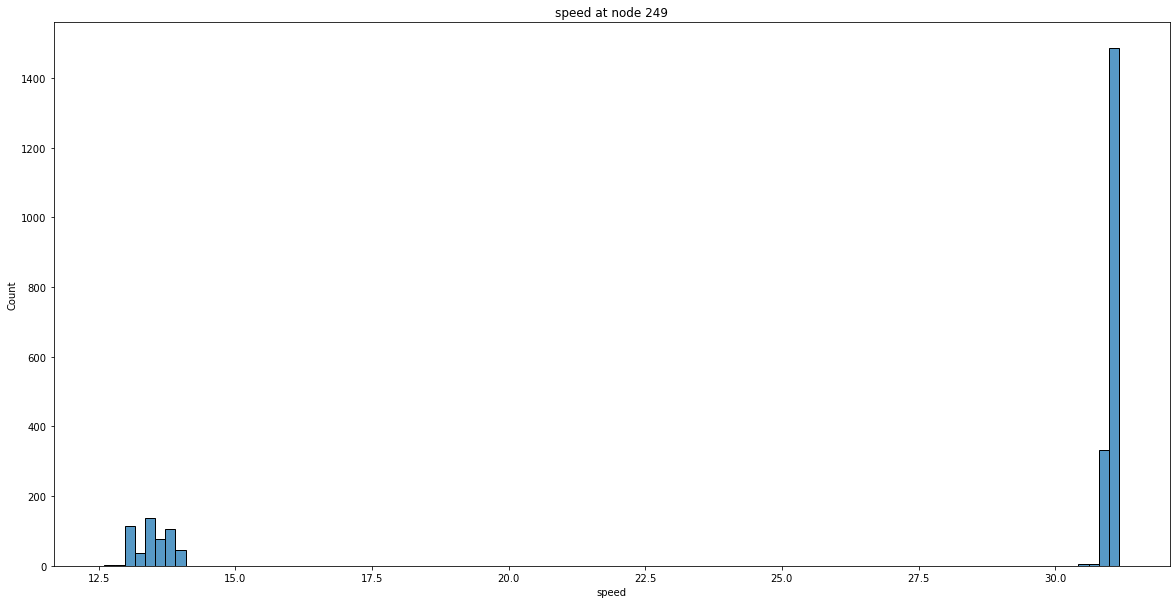

In [13]:
df_early = df.loc[df['activeNode'] == 5, :]
fig = plt.figure(figsize=(20,10), )
plt.title('speed at node 249')
sns.histplot(df_early['speed'], bins=100);

In [14]:
lap_type_divider = 20

first_lap_list = df_early.loc[df_early['speed'] < lap_type_divider, 'folder_lap'].unique()
later_lap_list = df_early.loc[df_early['speed'] >= lap_type_divider, 'folder_lap'].unique()

#### Create lap time df

In [15]:
laps = pd.DataFrame(df.groupby(by='folder_lap')['time'].describe()[['max', 'min']])
laps

,max,min
folder_lap,,
01_25_2022/13_00_25_1,732.738281,712.988281
01_25_2022/13_00_25_2,751.438293,732.788330
01_25_2022/13_00_25_3,770.038330,751.488281
01_25_2022/13_00_25_4,788.238281,770.088318
01_25_2022/13_00_25_5,806.788330,788.288330
...,...,...
01_26_2022/01_55_18_5,27442.250000,27423.949219
01_26_2022/01_55_18_6,27460.800781,27442.300781
01_26_2022/01_55_18_7,27479.599609,27460.849609


#### Calculate lap times

In [16]:
laps['lap_time'] = laps['max'] - laps['min']
laps['lap_time'].describe()

count    1588.000000
mean       18.512375
std         0.500564
min        18.000000
25%        18.250000
50%        18.349609
75%        18.451172
max        21.648438
Name: lap_time, dtype: float64

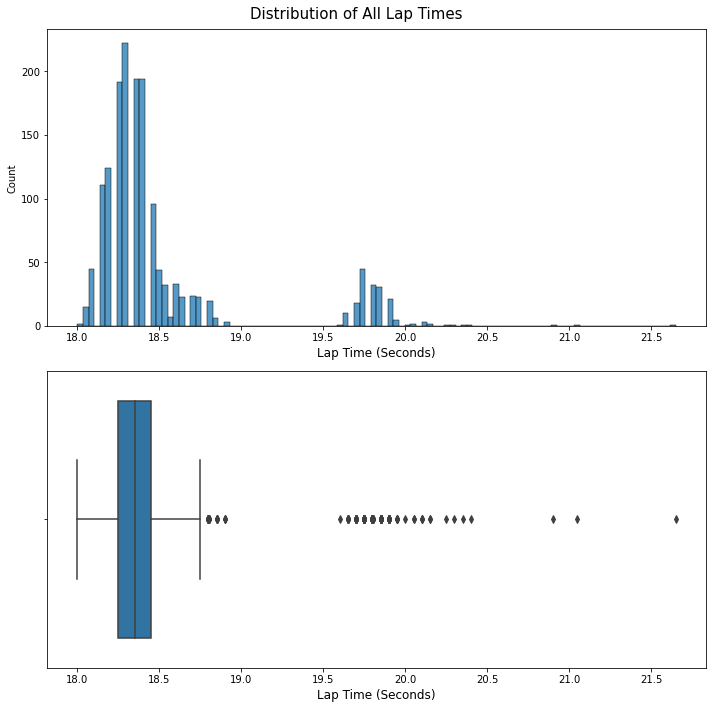

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))
plt.suptitle('Distribution of All Lap Times', size=15)
ax[0] = sns.histplot(x='lap_time', data=laps, bins='auto', ax=ax[0])
ax[0].set_xlabel('Lap Time (Seconds)', size=12)
ax[1] = sns.boxplot(x='lap_time', data=laps, ax=ax[1])
ax[1].set_xlabel('Lap Time (Seconds)', size=12)
plt.tight_layout();

#### Merge lap times into dataframe to make sorting easier

In [18]:
df = pd.merge(left=df, right=laps['lap_time'], left_on='folder_lap', right_index=True).copy()

#### Cut laps longer and shorter than specified length

In [19]:
df_pared = df.loc[(df['lap_time'] < lap_max_cutoff) & (df['lap_time'] > lap_min_cutoff), :].copy()
df_pared.shape

(583415, 29)

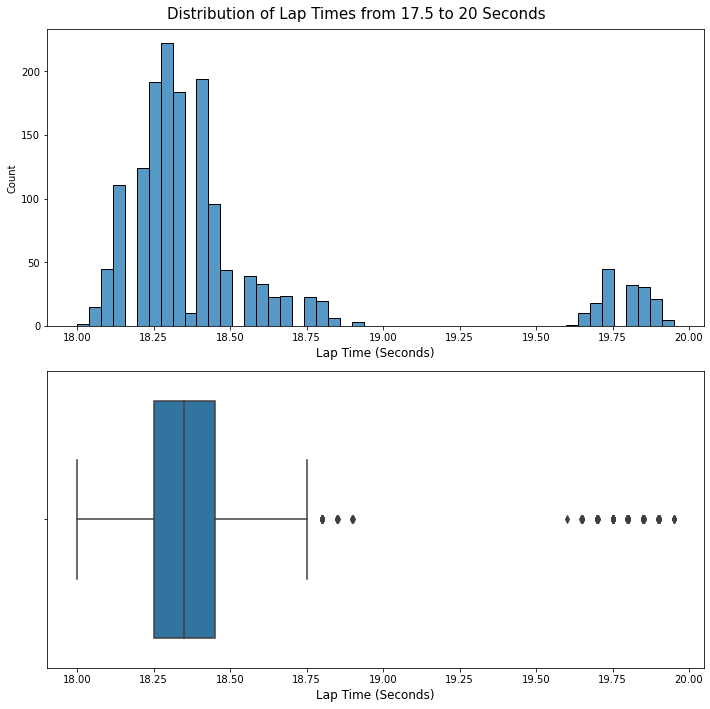

In [20]:
laps = laps.loc[(laps['lap_time'] < lap_max_cutoff) & (laps['lap_time'] > lap_min_cutoff), :].copy()

fig, ax = plt.subplots(2, 1, figsize=(10,10))
plt.suptitle(f'Distribution of Lap Times from {lap_min_cutoff} to {lap_max_cutoff} Seconds', size=15)
ax[0] = sns.histplot(x='lap_time', data=laps, bins=50, ax=ax[0])
ax[0].set_xlabel('Lap Time (Seconds)', size=12)
ax[1] = sns.boxplot(x='lap_time', data=laps, ax=ax[1])
ax[1].set_xlabel('Lap Time (Seconds)', size=12)
plt.tight_layout();

#### Remove incomplete laps that happen to have valid lap times

> Note: There are probably better ways to do this.

In [21]:
# not needed for the newer laps
if train_type == 'manual':
    bad_laps = []
    for fl in df_pared['folder_lap'].unique():
        if len(df_pared.loc[df_pared['folder_lap'] == fl, 'activeNode'].unique() ) < 249:
            bad_laps.append(fl)
    print(f'Number of "bad" laps: {len(bad_laps)}')

    ## Add any laps found "by hand" (via plotting) to list.
    if train_type and train_type == 'manual':
        bad_laps.append(('01_14_2022/14_07_24', 149))

    df_pared = df_pared.loc[~df_pared['folder_lap'].isin(bad_laps), :].copy()
    df_pared['lap_time'].describe()

#### Separate lap types

In [22]:
df_first_laps = df_pared.loc[df_pared['folder_lap'].isin(first_lap_list)].copy()
df_later_laps = df_pared.loc[df_pared['folder_lap'].isin(later_lap_list)].copy()

#### First laps

In [23]:
df_first_laps['lap_time'].describe()

count    64684.000000
mean        19.792005
std          0.076201
min         19.599609
25%         19.750000
50%         19.799805
75%         19.849609
max         19.950195
Name: lap_time, dtype: float64

##### Pare outliers from first laps

In [24]:
first_lap_cut = 19.8 # entirely arbitrary
display(len(df_first_laps.loc[df_first_laps['lap_time'] <= first_lap_cut, :]))
df_first_laps = df_first_laps.loc[df_first_laps['lap_time'] <= first_lap_cut, :].copy()
# len(df_first_laps)

37203

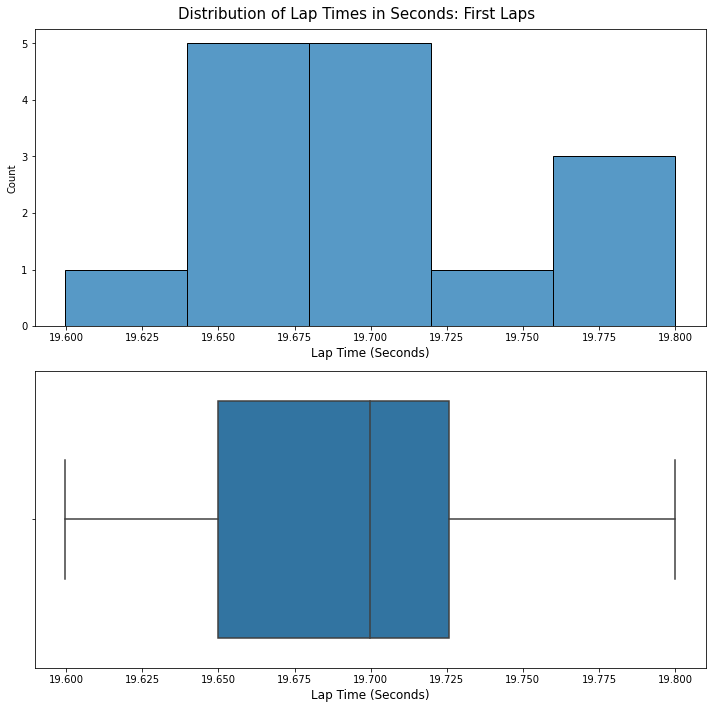

In [25]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))
plt.suptitle('Distribution of Lap Times in Seconds: First Laps', size=15)
ax[0] = sns.histplot(x=df_first_laps['lap_time'].unique(), bins='auto', ax=ax[0])
ax[0].set_xlabel('Lap Time (Seconds)', size=12)
ax[1] = sns.boxplot(x=df_first_laps['lap_time'].unique(), ax=ax[1])
ax[1].set_xlabel('Lap Time (Seconds)', size=12)
plt.tight_layout();

#### Later laps

In [26]:
df_later_laps['lap_time'].describe()

count    518731.000000
mean         18.346045
std           0.158790
min          18.000000
25%          18.250000
50%          18.300781
75%          18.400391
max          18.900391
Name: lap_time, dtype: float64

##### Pare outliers from later lap times

In [30]:
later_lap_cut = 18.25 # again, arbitrary
display(len(df_later_laps.loc[df_later_laps['lap_time'] <= later_lap_cut, :]))
df_later_laps = df_later_laps.loc[df_later_laps['lap_time'] <= later_lap_cut, :].copy()
# len(df_later_laps)

177691

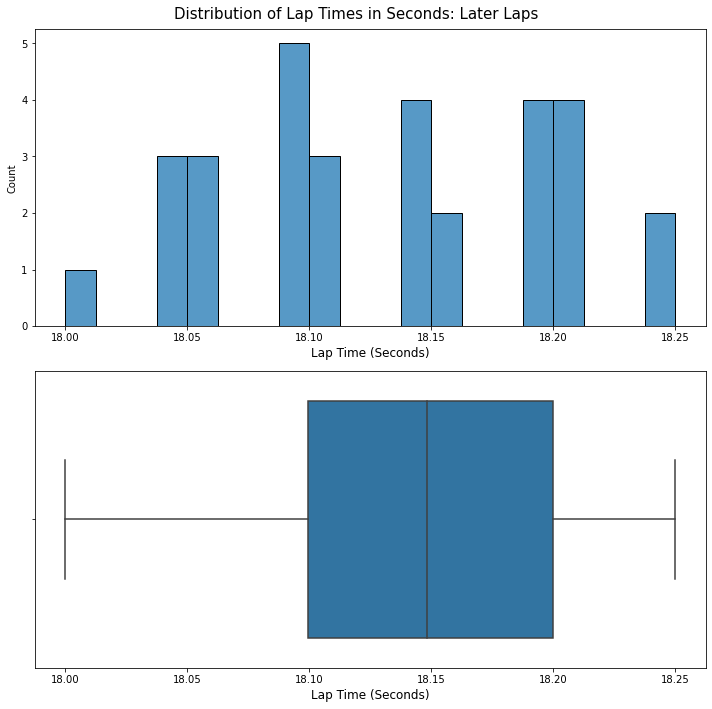

In [31]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))
plt.suptitle('Distribution of Lap Times in Seconds: Later Laps', size=15)
ax[0] = sns.histplot(x=df_later_laps['lap_time'].unique(), bins=20, ax=ax[0])
ax[0].set_xlabel('Lap Time (Seconds)', size=12)
ax[1] = sns.boxplot(x=df_later_laps['lap_time'].unique(), ax=ax[1])
ax[1].set_xlabel('Lap Time (Seconds)', size=12)
plt.tight_layout();

#### Mark lap types

In [32]:
df_first_laps.loc[:, 'lap_type'] = 'first'
df_later_laps.loc[:, 'lap_type'] = 'later'

#### Combine pared laps

In [33]:
df_combined = pd.concat([df_first_laps, df_later_laps])
df_combined['first_lap'] = (df_combined['lap_type'] == 'first') * 1
df_combined.head()

,steering,throttle,speed,image,hit,time,accel_x,accel_y,accel_z,gyro_x,...,pos_z,vel_x,vel_y,vel_z,lap,folder,folder_lap,lap_time,lap_type,first_lap
766,-0.045644,0.972396,6.974114,12435.94.PNG,none,12435.940430,12.047630,11.906170,20.755671,-0.000681,...,48.543098,0.077530,-0.225656,6.970031,1,01_25_2022/16_15_50,01_25_2022/16_15_50_1,19.799805,first,1
767,-0.045644,0.972396,7.331553,12435.99.PNG,none,12435.990234,0.032386,3.775789,6.711149,0.000576,...,48.183861,-0.039138,0.088674,7.330912,1,01_25_2022/16_15_50,01_25_2022/16_15_50_1,19.799805,first,1
768,-0.045644,0.972396,7.698823,12436.04.PNG,none,12436.040039,0.038004,-0.865520,7.630444,0.000829,...,47.808739,-0.037229,0.106391,7.697998,1,01_25_2022/16_15_50,01_25_2022/16_15_50_1,19.799805,first,1
769,-0.091847,0.974485,8.089861,12436.09.PNG,none,12436.089844,-0.146884,-1.999657,8.106422,0.000988,...,47.414970,-0.049751,0.016513,8.089691,1,01_25_2022/16_15_50,01_25_2022/16_15_50_1,19.799805,first,1
770,-0.091847,0.974485,8.490166,12436.14.PNG,none,12436.139648,0.184599,-37.486408,6.197834,0.004141,...,47.003052,-0.050176,-0.436539,8.478787,1,01_25_2022/16_15_50,01_25_2022/16_15_50_1,19.799805,first,1


In [34]:
combined_laps = df_combined[['folder_lap', 'lap_time', 'lap_type']].drop_duplicates().copy()
combined_laps = combined_laps.set_index('folder_lap').copy()

combined_laps['lap_time'].describe()

count    581.000000
mean      18.443421
std        0.572302
min       18.000000
25%       18.150391
50%       18.201172
75%       18.250000
max       19.799988
Name: lap_time, dtype: float64

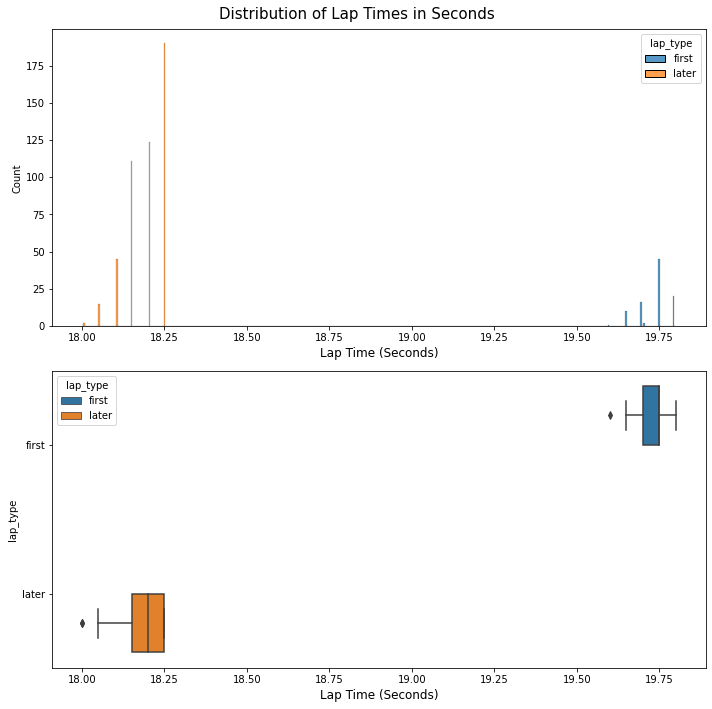

In [35]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))
plt.suptitle('Distribution of Lap Times in Seconds', size=15)
ax[0] = sns.histplot(x='lap_time', data=combined_laps, hue='lap_type', bins=200, ax=ax[0], multiple='dodge',)# log_scale=(0, 10))
ax[0].set_xlabel('Lap Time (Seconds)', size=12)
ax[1] = sns.boxplot(x='lap_time', y='lap_type', data=combined_laps, hue='lap_type', ax=ax[1])
ax[1].set_xlabel('Lap Time (Seconds)', size=12)
plt.tight_layout();

> and never the twain shall meet.

In [36]:
# redundant 
# df_data = df_combined.loc[((df_combined['lap_type'] == 'first') & (df_combined['lap_time'] < first_lap_cut))
                              # | ((df_combined['lap_type'] == 'later') & (df_combined['lap_time'] < later_lap_cut)), : ].copy()
# df_data = df_data.sort_values(by=['folder_lap', 'time'], ascending=True).reset_index(drop=True)
df_data = df_combined.copy()

### Look at collisions

In [ ]:
no_hit_laps = []
for fl in df_data['folder_lap'].unique():
    # print(df_data.loc[df_data['folder_lap'] == fl, 'hit'].value_counts())
    if len(df_data.loc[df_data['folder_lap'] == fl, 'hit'].unique()) == 1:
        no_hit_laps.append(fl)
no_hit_laps

In [ ]:
df_no_hit = df_data.loc[df_data['folder_lap'].isin(no_hit_laps), :]

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))
plt.suptitle('Distribution of Lap Times in Seconds', size=15)
ax[0] = sns.histplot(x='lap_time', data=df_no_hit, hue='lap_type', bins='auto', ax=ax[0], multiple='dodge',)# log_scale=(0, 10))
ax[0].set_xlabel('Lap Time (Seconds)', size=12)
ax[1] = sns.boxplot(x='lap_time', y='lap_type', data=df_no_hit, hue='lap_type', ax=ax[1])
ax[1].set_xlabel('Lap Time (Seconds)', size=12)
plt.tight_layout();

In [ ]:
df_no_hit['lap_time'].describe()

In [ ]:
one_hit_laps = []
for fl in df_data['folder_lap'].unique():
    # print(df_data.loc[df_data['folder_lap'] == fl, 'hit'].value_counts())
    if len(df_data.loc[df_data['folder_lap'] == fl, 'hit'].unique()) == 2:
        # print(df_data.loc[df_data['folder_lap'] == fl, 'hit'].value_counts())
        one_hit_laps.append(fl)
# one_hit_laps

In [ ]:
df_one_hit = df_data.loc[df_data['folder_lap'].isin(one_hit_laps), :]

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))
plt.suptitle('Distribution of Lap Times in Seconds', size=15)
ax[0] = sns.histplot(x='lap_time', data=df_one_hit, hue='lap_type', bins='auto', ax=ax[0], multiple='dodge',)# log_scale=(0, 10))
ax[0].set_xlabel('Lap Time (Seconds)', size=12)
ax[1] = sns.boxplot(x='lap_time', y='lap_type', data=df_one_hit, hue='lap_type', ax=ax[1])
ax[1].set_xlabel('Lap Time (Seconds)', size=12)
plt.tight_layout();

In [ ]:
df_one_hit['lap_time'].describe()

#### Save lap data for plotting

In [37]:
for d in [df_data, df_first_laps, df_later_laps]:
    d = d.sort_values(by=['folder_lap', 'time']).copy()
    d = d.reset_index(drop=True).copy()

# df_data = df_data.sort_values(by=['folder_lap', 'time']).copy()
# df_data = df_data.reset_index(drop=True).copy()

In [38]:
# For plotting trajectories later
df_data.to_pickle(combined_laps_file)
df_first_laps.to_pickle(first_laps_file)
df_later_laps.to_pickle(later_laps_file)

### Examine IMU data

In [ ]:
X_imu = df_data[imu_data]
X_imu.describe()

### Look for IMU Outliers
> Note: This is mucking about by hand with arbitrarily chosen values. You might be able to skip this.

In [ ]:
colors = [f'C{i}' for i in range(len(X_imu.columns))]

fig, ax = plt.subplots(2, 3, figsize=(21, 12))

fig.suptitle('IMU Data', size=15)

accel_scale = max(max(X_imu[col].max(), abs(X_imu[col].min())) for col in ['accel_x', 'accel_y', 'accel_z']) * 1.1
X_imu['accel_x'].plot(ax=ax[0][0], xticks=[], ylim=(-accel_scale, accel_scale), xlabel='Accelerometer X', color=colors[0])
X_imu['accel_y'].plot(ax=ax[0][1], xticks=[], ylim=(-accel_scale, accel_scale), xlabel='Accelerometer Y', color=colors[1])
X_imu['accel_z'].plot(ax=ax[0][2], xticks=[], ylim=(-accel_scale, accel_scale), xlabel='Accelerometer Z', color=colors[2])

gyro_scale = max(max(X_imu[col].max(), abs(X_imu[col].min())) for col in ['gyro_x', 'gyro_y', 'gyro_z']) * 1.1
X_imu['gyro_x'].plot(ax=ax[1][0], xticks=[], ylim=(-gyro_scale, gyro_scale), xlabel='Gyroscope X', color=colors[3])
X_imu['gyro_y'].plot(ax=ax[1][1], xticks=[], ylim=(-gyro_scale, gyro_scale), xlabel='Gyroscope Y', color=colors[4])
X_imu['gyro_z'].plot(ax=ax[1][2], xticks=[], ylim=(-gyro_scale, gyro_scale), xlabel='Gyroscope Z', color=colors[5])

# vel_scale = max(max(X_imu[col].max(), abs(X_imu[col].min())) for col in ['vel_x', 'vel_y', 'vel_z']) * 1.1
# X_imu['vel_x'].plot(ax=ax[2][0], xticks=[], ylim=(-vel_scale, vel_scale), xlabel='Velocity X', color=colors[6])
# X_imu['vel_y'].plot(ax=ax[2][1], xticks=[], ylim=(-vel_scale, vel_scale), xlabel='Velocity Y', color=colors[7])
# X_imu['vel_z'].plot(ax=ax[2][2], xticks=[], ylim=(-vel_scale, vel_scale), xlabel='Velocity Z', color=colors[8])

for i in range(len(ax)):
    for j in range(len(ax[0])):
        ax[i][j].axhline(y=0, color='black', linewidth=0.5)

plt.tight_layout();

In [ ]:
imu_outliers = set()

In [ ]:
## probably collisions
display(X_imu.loc[(X_imu['accel_x'] < -60) | (X_imu['accel_x'] > 60)])
imu_outliers.update(X_imu.loc[(X_imu['accel_x'] < -60) | (X_imu['accel_x'] > 60)].index.tolist())

In [ ]:
display(X_imu.loc[(X_imu['accel_y'] < -50) | (X_imu['accel_y'] > 50)])
imu_outliers.update(X_imu.loc[(X_imu['accel_y'] < -50) | (X_imu['accel_y'] > 50)].index.tolist())

In [ ]:
## probably collisions
display(X_imu.loc[(X_imu['accel_z'] < -50) | (X_imu['accel_z'] > 50)])
imu_outliers.update(X_imu.loc[(X_imu['accel_z'] < -50) | (X_imu['accel_z'] > 50)].index.tolist())

In [ ]:
display(X_imu.loc[(X_imu['gyro_x'] < -0.01) | (X_imu['gyro_x'] > 0.01)])
imu_outliers.update(X_imu.loc[(X_imu['gyro_x'] < -0.01) | (X_imu['gyro_x'] > 0.01)].index.tolist())

In [ ]:
display(X_imu.loc[(X_imu['gyro_y'] < -0.015) | (X_imu['gyro_y'] > 0.015)])
imu_outliers.update(X_imu.loc[(X_imu['gyro_y'] < -0.015) | (X_imu['gyro_y'] > 0.015)].index.tolist())

In [ ]:
display(X_imu.loc[(X_imu['gyro_z'] < -0.01) | (X_imu['gyro_z'] > 0.01)])
imu_outliers.update(X_imu.loc[(X_imu['gyro_z'] < -0.01) | (X_imu['gyro_z'] > 0.01)].index.tolist())

In [ ]:
# DON'T DO THIS BASED ON MY NUMBERS.
print(imu_outliers)

In [ ]:
X_imu = X_imu.drop(imu_outliers).copy()

#### Plot

In [ ]:
colors = [f'C{i}' for i in range(len(X_imu.columns))]

fig, ax = plt.subplots(2, 3, figsize=(21, 12))

fig.suptitle('IMU Data', size=15)

accel_scale = max(max(X_imu[col].max(), abs(X_imu[col].min())) for col in ['accel_x', 'accel_y', 'accel_z']) * 1.1
X_imu['accel_x'].plot(ax=ax[0][0], xticks=[], ylim=(-accel_scale, accel_scale), xlabel='Accelerometer X', color=colors[0])
X_imu['accel_y'].plot(ax=ax[0][1], xticks=[], ylim=(-accel_scale, accel_scale), xlabel='Accelerometer Y', color=colors[1])
X_imu['accel_z'].plot(ax=ax[0][2], xticks=[], ylim=(-accel_scale, accel_scale), xlabel='Accelerometer Z', color=colors[2])

gyro_scale = max(max(X_imu[col].max(), abs(X_imu[col].min())) for col in ['gyro_x', 'gyro_y', 'gyro_z']) * 1.1
X_imu['gyro_x'].plot(ax=ax[1][0], xticks=[], ylim=(-gyro_scale, gyro_scale), xlabel='Gyroscope X', color=colors[3])
X_imu['gyro_y'].plot(ax=ax[1][1], xticks=[], ylim=(-gyro_scale, gyro_scale), xlabel='Gyroscope Y', color=colors[4])
X_imu['gyro_z'].plot(ax=ax[1][2], xticks=[], ylim=(-gyro_scale, gyro_scale), xlabel='Gyroscope Z', color=colors[5])

# vel_scale = max(max(X_imu[col].max(), abs(X_imu[col].min())) for col in ['vel_x', 'vel_y', 'vel_z']) * 1.1
# X_imu['vel_x'].plot(ax=ax[2][0], xticks=[], ylim=(-vel_scale, vel_scale), xlabel='Velocity X', color=colors[6])
# X_imu['vel_y'].plot(ax=ax[2][1], xticks=[], ylim=(-vel_scale, vel_scale), xlabel='Velocity Y', color=colors[7])
# X_imu['vel_z'].plot(ax=ax[2][2], xticks=[], ylim=(-vel_scale, vel_scale), xlabel='Velocity Z', color=colors[8])

for i in range(len(ax)):
    for j in range(len(ax[0])):
        ax[i][j].axhline(y=0, color='black', linewidth=0.5)

plt.tight_layout();

*Comment*:
* The sheer number of laps makes it difficult to analyize when plotted together like thist

### Examine Telemetry Data

In [ ]:
## Uncomment to drop the IMU ourliers if you care to
# df_data = df_data.drop(imu_oulier_indices).copy()

### Random Lap Cut
Found by plotting

In [42]:
# df_data = df_one_hit.copy()
# df_data = df_data.loc[df_data['folder_lap'] != '01_14_2022/13_00_37_177', : ].copy()
df_data = df_data.sort_values(by=['folder_lap', 'time']).copy()
df_data = df_data.reset_index(drop=True)

### Create Telemety DF

In [43]:
X_telem = df_data[telemetry_columns]
X_telem.describe()

,speed,yaw,activeNode,first_lap
count,214894.000000,214894.000000,214894.000000,214894.000000
mean,25.784119,182.315506,119.089486,0.173123
std,4.448546,108.925598,68.910360,0.378354
min,6.505294,-0.005451,0.000000,0.000000
25%,22.301160,89.415241,64.000000,0.000000
50%,25.333395,193.197952,114.000000,0.000000
75%,30.343008,271.421898,175.000000,0.000000
max,31.318180,359.992615,249.000000,1.000000


#### Plot

In [ ]:
# X_telem = X_telem.reset_index(drop=True)

In [40]:
X_telem.columns

Index(['speed', 'yaw', 'activeNode', 'first_lap'], dtype='object')

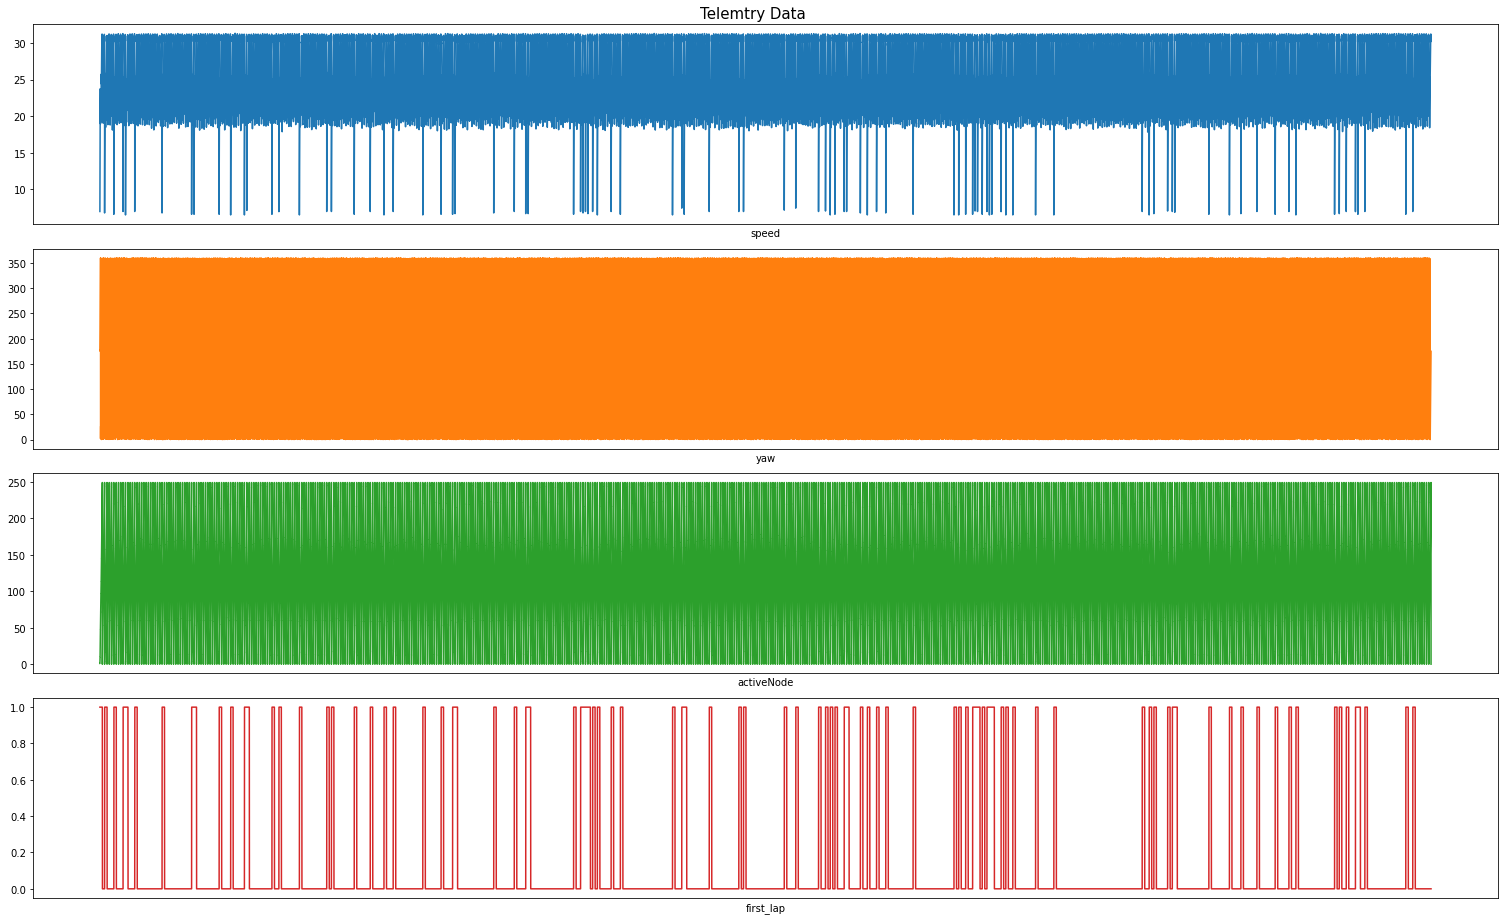

In [44]:
colors = [f'C{i}' for i in range(len(X_telem.columns))]
fig, ax = plt.subplots(len(telemetry_columns), 1, figsize=(21, len(telemetry_columns)*3 +1))
fig.suptitle('Telemtry Data', size=15)
for i in range(len(ax)):
    ax[i] = X_telem[telemetry_columns[i]].plot(ax=ax[i], xticks=[], xlabel=telemetry_columns[i], color=colors[i])
plt.tight_layout();

*Comment*:
* see above. a mess.

### Dummify Nodes

In [ ]:
if dummify_nodes and 'activeNode' in telemetry_columns:
    X_telem = pd.get_dummies(data=X_telem, columns=['activeNode'])
X_telem.columns

### Save Telemetry Data

In [45]:
X_telem

,speed,yaw,activeNode,first_lap
0,6.975486,177.881897,1,1
1,7.332412,177.846802,1,1
2,7.699350,177.696701,1,1
3,8.091217,177.461395,1,1
4,8.491880,177.206604,1,1
...,...,...,...,...
214889,30.743731,170.582108,247,0
214890,30.799549,171.569794,248,0
214891,30.859249,172.511795,249,0
214892,30.915739,173.962494,249,0


#### On second thought, let's take a look at pitch and roll.

In [ ]:
# X_telem['pitch'].hist(bins=50);

# X_telem['roll'].hist(bins=50);

> They don't look particularly helpful, so I'm dropping them

In [ ]:
# X_telem = X_telem.drop(columns=['pitch', 'roll']).copy() # trying leavin them in

In [46]:
## Save as pickle
X_telem.to_pickle(telem_dataset_file)

## Images

### Create Image Array
> This is a hilariously slow way to do this.

In [ ]:
# X_img = np.empty((120, 160, 1))
# X_img = np.empty(len(df_data))

In [47]:
## try saving to jpg (svaes memory, takes a long time)
for row in df_data.itertuples():
    png_file = f'{training_data_directory}/{row.folder}/images/{row.image}'
    jpg_dir = f'{training_data_directory}/{row.folder}/images/jpg'
    os.makedirs(jpg_dir, exist_ok=True)
    jpg_file = f'{jpg_dir}/{row.image[:-4]}.jpg'
    if not os.path.isfile(jpg_file): 
        load_img(png_file, color_mode='grayscale',).save(jpg_file)

In [48]:
image_files = [ f'{training_data_directory}/{row.folder}/images/jpg/{row.image[:-4]}.jpg' for row in df_data.itertuples()]

In [49]:
X_img = np.ndarray(shape=(len(df_data), 120, 160, 1),
                     dtype='uint8')
for i in range(len(df_data)):
    X_img[i] = img_to_array(load_img(image_files[i], color_mode='grayscale',))

In [50]:
X_img[0]

array([[[172],
        [172],
        [171],
        ...,
        [145],
        [145],
        [145]],

       [[173],
        [172],
        [172],
        ...,
        [145],
        [145],
        [145]],

       [[174],
        [174],
        [173],
        ...,
        [146],
        [146],
        [146]],

       ...,

       [[ 81],
        [ 91],
        [ 96],
        ...,
        [ 80],
        [ 82],
        [ 84]],

       [[ 92],
        [104],
        [100],
        ...,
        [ 82],
        [ 84],
        [ 86]],

       [[193],
        [195],
        [164],
        ...,
        [ 82],
        [ 84],
        [ 86]]], dtype=uint8)

In [51]:
X_img.shape

(214894, 120, 160, 1)

## Datasets

### Create Targets

In [52]:
## Target: throttle and steering data
y = df_data.loc[:, ['steering', 'throttle']].to_numpy().copy()

## Verify size
print(f'X.shape: {X_img.shape}')
print(f'y.shape: {y.shape}')

X.shape: (214894, 120, 160, 1)
y.shape: (214894, 2)


### Save Datasets

In [53]:
## Save as binary NumPy .npy format
with open(image_dataset_file, 'wb') as X_out:
    np.save(file=X_out, arr=X_img)
with open(target_dataset_file, 'wb') as y_out:
    np.save(file=y_out, arr=y)